# 머신러닝

### * 오류 메세지 관리

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

### * import

In [28]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

## 1. 데이터셋 읽기


In [4]:
data = pd.read_csv('/Users/j/Desktop/AI camp/2차 프로젝트/연습/WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.shape

(1470, 45)

## 2. EDA
- 데이터셋의 특성을 파악하기 위해 EDA를 진행한다.
- EDA를 통해 데이터셋의 분포, 결측치, 이상치 등을 확인한다.
- 데이터셋의 특성을 파악한 후, 모델링을 진행하기 위한 전처리 방향을 설정한다.
- EDA는 전체 데이터셋을 대상으로 진행합니다.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1470 non-null   int64 
 1   Age                       1470 non-null   int64 
 2   Attrition                 1470 non-null   object
 3   BusinessTravel            1470 non-null   object
 4   DailyRate                 1470 non-null   int64 
 5   Department                1470 non-null   object
 6   DistanceFromHome          1470 non-null   int64 
 7   Education                 1470 non-null   object
 8   EducationField            1470 non-null   object
 9   EmployeeCount             1470 non-null   int64 
 10  EmployeeNumber            1470 non-null   int64 
 11  EnvironmentSatisfaction   1470 non-null   int64 
 12  Gender                    1470 non-null   object
 13  HourlyRate                1470 non-null   int64 
 14  JobInvolvement          

In [8]:
# 불필요한 열 제거
data = data.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)

In [9]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Unnamed: 0                1470 non-null   int64 
 1   Age                       1470 non-null   int64 
 2   Attrition                 1470 non-null   object
 3   BusinessTravel            1470 non-null   object
 4   DailyRate                 1470 non-null   int64 
 5   Department                1470 non-null   object
 6   DistanceFromHome          1470 non-null   int64 
 7   Education                 1470 non-null   object
 8   EducationField            1470 non-null   object
 9   EnvironmentSatisfaction   1470 non-null   int64 
 10  Gender                    1470 non-null   object
 11  HourlyRate                1470 non-null   int64 
 12  JobInvolvement            1470 non-null   int64 
 13  JobLevel                  1470 non-null   object
 14  JobRole                 

### 2-1. Target 분포 확인

In [11]:
print("--개수--------------")
print(data['Attrition'].value_counts())
print("--비율--------------")
print(data['Attrition'].value_counts(normalize=True))

--개수--------------
Attrition
No     1233
Yes     237
Name: count, dtype: int64
--비율--------------
Attrition
No     0.838776
Yes    0.161224
Name: proportion, dtype: float64


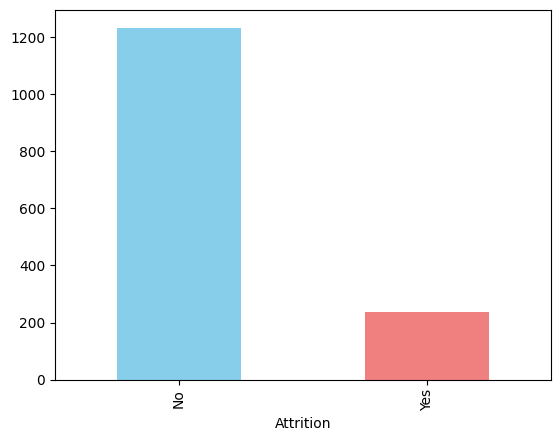

In [12]:
data['Attrition'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral']);

### 2-2. 이상치 및 결측치 확인

In [13]:
## 결측치 확인
data.isna().sum()

Unnamed: 0                  0
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsBeforeCompany          0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
DailyRateG

In [14]:
# 이상치 확인

In [15]:
# IQR 기반으로 Outlier 값 조회 메소드

def is_outlier(data, whis=1.5):
    """
    IQR 기반으로 Outlier 값 조회 메소드
    parameter
        data: outlier를 찾을 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        bool type ndarray: 각 원소별 outlier 여부 (True: Outlier(이상치), False: 정상범위값)
    """
    q1 = np.quantile(data, q=0.25)
    q3 = np.quantile(data, q=0.75)
    IQR = q3 - q1
    return (data < q1 - IQR * whis) | (data > q3 + IQR * whis)


def get_normal_range(data, whis=1.5):
    """
    IQR 기반으로 정상범위 조회 메소드
    parameter
        data: 조회할 대상 데이터
        whis: IQR에 몇배를 극단치 계산에 사용할 지 비율. rate를 크게하면 outlier범위를 넓게 잡는다. 작게 주면 범위를 좁게 잡는다.
    return
        tuple: (lower_bound, upper_bound) - 정상범위의 하한값과 상한값
    """
    q1 = np.nanquantile(data, q=0.25)
    q3 = np.nanquantile(data, q=0.75)
    IQR = q3 - q1
    lower_bound = q1 - IQR * whis
    upper_bound = q3 + IQR * whis
    return lower_bound, upper_bound

In [16]:
## 시각화 (number 타입만)
### 나눠서 그리기 위해 컬럼이름들 조회
c = data.select_dtypes(include=[np.number]).drop(columns=data.columns[0]).columns
len(c)

22

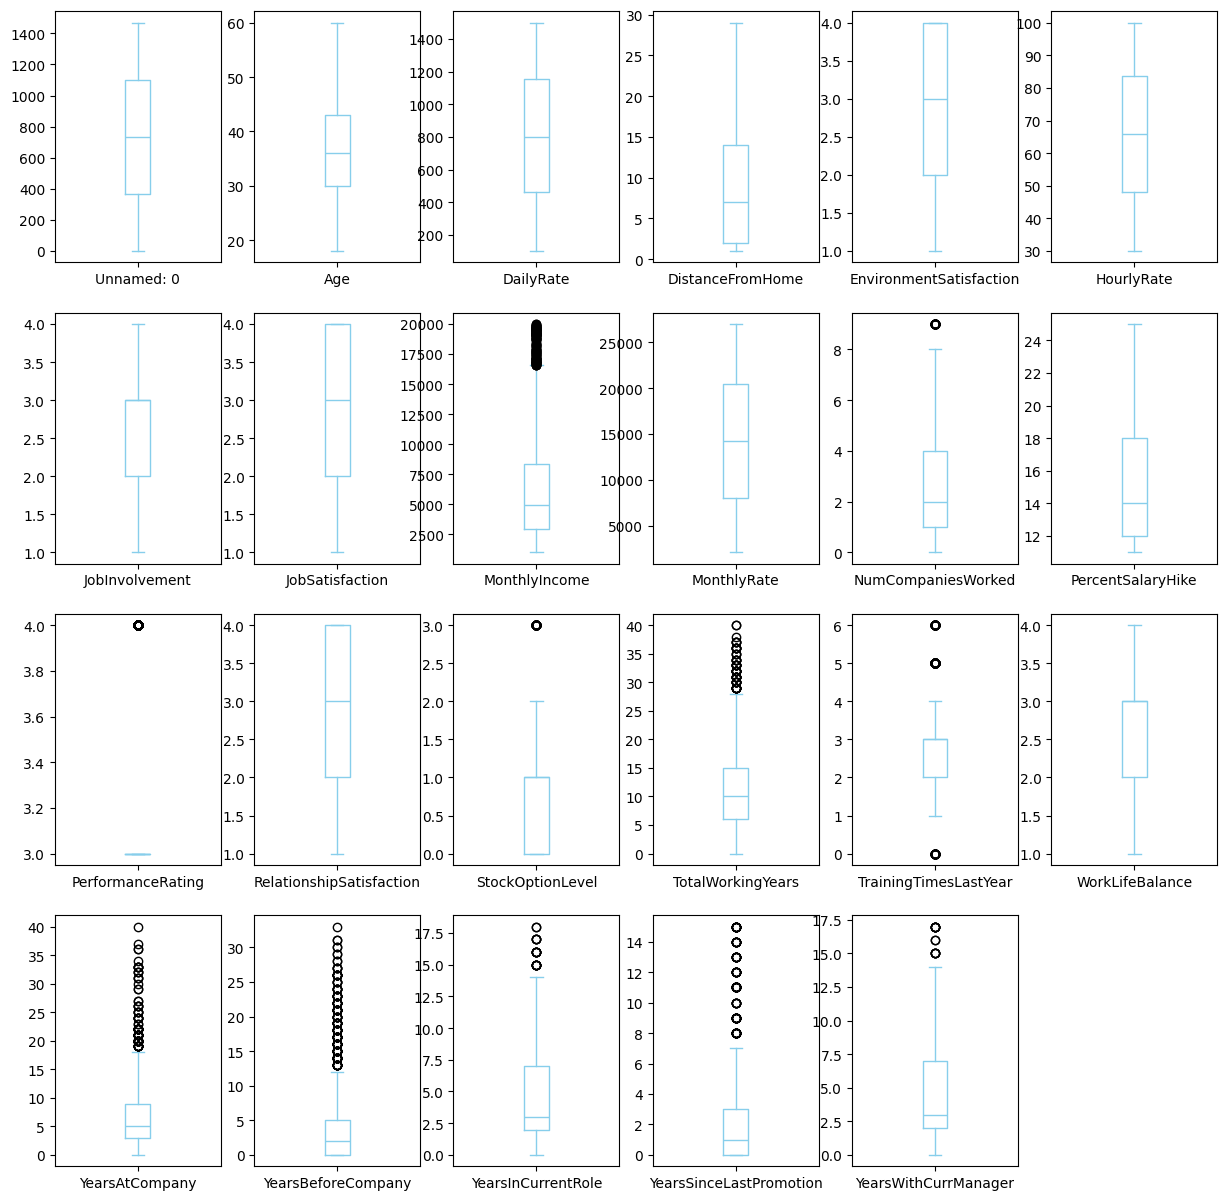

In [17]:
# subplots=True, layout=(3, 4): 3행 4열로 나눠서
data.select_dtypes(include=[np.number]).plot(
    kind='box', 
    subplots=True, 
    layout=(4, 6), 
    figsize=(15, 15), 
    color='skyblue');

## 3. 데이터셋 준비

In [19]:
# 범주형 변수 원-핫 인코딩
data = pd.get_dummies(data, drop_first=True)

# 타겟 변수와 특성 분리
X = data.drop('Attrition_Yes', axis=1)
y = data['Attrition_Yes']

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 특성 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 3-1. 데이터셋 변환

In [20]:
# PyTorch 데이터셋으로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values)

### 3-2. 신경망 모델 정의

In [21]:
# 신경망 모델 정의
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

### 3-3. 모델 초기화 및 사전 작업

In [22]:
# 모델 초기화
input_size = X_train_scaled.shape[1]
model = Net(input_size)

In [32]:
# 손실 함수와 옵티마이저 정의
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 학습 과정을 추적하기 위한 리스트
train_losses = []
train_accuracies = []

## 4. 모델 학습

In [36]:
# 모델 학습
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    epoch_losses = []
    epoch_accuracies = []
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y.unsqueeze(1))
        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        accuracy = ((outputs > 0.5).float() == batch_y.unsqueeze(1)).float().mean()
        epoch_accuracies.append(accuracy.item())
    
    avg_loss = np.mean(epoch_losses)
    avg_accuracy = np.mean(epoch_accuracies)
    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')

Epoch [10/100], Loss: 0.0055, Accuracy: 0.9983
Epoch [20/100], Loss: 0.0055, Accuracy: 0.9983
Epoch [30/100], Loss: 0.0090, Accuracy: 0.9983
Epoch [40/100], Loss: 0.0040, Accuracy: 0.9992
Epoch [50/100], Loss: 0.0022, Accuracy: 0.9992
Epoch [60/100], Loss: 0.0018, Accuracy: 1.0000
Epoch [70/100], Loss: 0.0043, Accuracy: 0.9992
Epoch [80/100], Loss: 0.0014, Accuracy: 1.0000
Epoch [90/100], Loss: 0.0004, Accuracy: 1.0000
Epoch [100/100], Loss: 0.0025, Accuracy: 0.9992


## 5. 모델 평가

In [37]:
# 모델 평가
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_class = (y_pred > 0.5).float()

accuracy = accuracy_score(y_test, y_pred_class)
print(f"Test Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class))

# 특성 중요도 계산
feature_importance = torch.abs(model.fc1.weight).mean(dim=0)
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance.detach().numpy()})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)


Test Accuracy: 0.87

Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.98      0.93       255
        True       0.50      0.15      0.24        39

    accuracy                           0.87       294
   macro avg       0.69      0.57      0.58       294
weighted avg       0.83      0.87      0.84       294



## 6. 특성 중요도 확인

In [26]:
# 특성 중요도 (첫 번째 레이어의 가중치를 사용하여 대략적인 중요도 추정)
feature_importance = torch.abs(model.fc1.weight).mean(dim=0)
feature_importance_df = pd.DataFrame({'feature': X.columns, 'importance': feature_importance.detach().numpy()})
feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).head(10)
print("\nTop 10 Important Features (based on first layer weights):")
print(feature_importance_df)


Top 10 Important Features (based on first layer weights):
                                     feature  importance
86    MonthlyIncomeGroups_P - 16000 => 17000    0.154953
51                              OverTime_Yes    0.151599
81    MonthlyIncomeGroups_K - 11000 => 12000    0.151091
87    MonthlyIncomeGroups_Q - 17000 => 18000    0.142597
129  YearsAtCompanyGroups_H - 25 => 30 Years    0.135611
84    MonthlyIncomeGroups_N - 14000 => 15000    0.123555
85    MonthlyIncomeGroups_O - 15000 => 16000    0.122780
126  YearsAtCompanyGroups_E - 11 => 15 Years    0.098398
10                        NumCompaniesWorked    0.091712
40                           JobLevel_Senior    0.090053


## 7. 시각화

In [29]:
# 그래프 그리기
plt.figure(figsize=(15, 15))

<Figure size 1500x1500 with 0 Axes>

<Figure size 1500x1500 with 0 Axes>

### 7-1. 학습 손실 그래프

Text(0, 0.5, 'Loss')

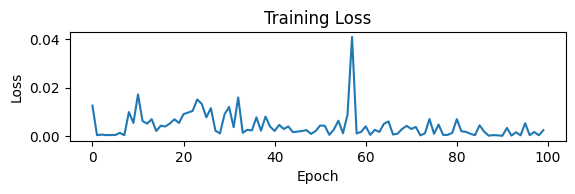

In [38]:
# 1. 학습 손실 그래프
plt.subplot(3, 1, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

### 7-2. 학습 정확도 그래프

Text(0, 0.5, 'Accuracy')

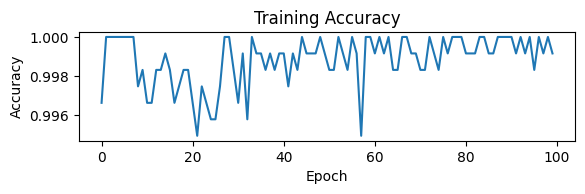

In [39]:
# 2. 학습 정확도 그래프
plt.subplot(3, 1, 2)
plt.plot(train_accuracies)
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

### 7-3. 특성 중요도 그래프

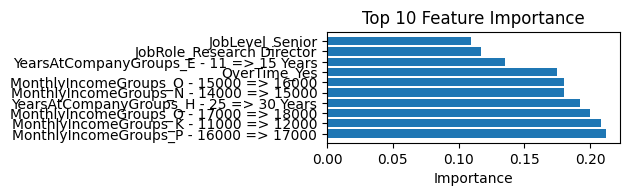

In [40]:
# 3. 특성 중요도 그래프
plt.subplot(3, 1, 3)
plt.barh(feature_importance_df['feature'][:10], feature_importance_df['importance'][:10])
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')

plt.tight_layout()
plt.show()